In [225]:
import numpy as np 
import pandas as pd 
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.preprocessing import OrdinalEncoder

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings("ignore",  category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning,)
warnings.filterwarnings("ignore", category=UserWarning)

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [226]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')

### Zmiana typu kolumn numerycznych na INT64

In [227]:
cols_to_convert = ['Time_spent_Alone', 'Social_event_attendance','Going_outside',  'Friends_circle_size','Post_frequency']
train_df[cols_to_convert] = train_df[cols_to_convert].astype('Int64')

### Tworzenie Flag dla brakujących danych i jednej kolumny sumującej braki

excluded_cols = ['id', 'Personality']
all_columns = train_df.columns
# Przetwarzanie pozostałych kolumn
for col in all_columns:
    if col not in excluded_cols:
        train_df[col + '_MISS'] = train_df[col].notna().astype(int)

columns = ['Time_spent_Alone_MISS','Stage_fear_MISS', 'Social_event_attendance_MISS', 'Going_outside_MISS','Drained_after_socializing_MISS', 
           'Friends_circle_size_MISS','Post_frequency_MISS']
train_df['not_MISS_total'] = train_df[columns].sum(axis=1)

### Tworzenie nowych kolumn

train_df['Time_Alone_dev_Outside'] = train_df['Time_spent_Alone'] / train_df['Going_outside']
train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].round(2).astype(float)
def Time_Alone_dev_Outside (x):
    try:
        x=float(x)
        if x <= 1:
            return 0
        elif x > 1 and x < 2:
            return 1
        elif x >= 2 and x < 100:
            return 2
        else:
            return 3
    except ValueError:
        return 3

train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].apply(Time_Alone_dev_Outside).astype('Int64')


train_df['Social_dev_Post'] = train_df['Social_event_attendance'] / train_df['Post_frequency']
train_df['Social_dev_Post']=train_df['Social_dev_Post'].round(2).astype(float)

def Social_dev_Post (x):
    try:
        x=float(x)
        if x == 0:
            return 0
        elif x > 0 and x < 0.33:
            return 1
        elif x == 0.33:
            return 2
        elif x > 0.33 and x < 0.5:
            return 1
        elif x == 0.5:
            return 4
        elif x > 0.5 and x < 0.67:
            return 1
        elif x == 0.67:
            return 4
        elif x > 0.67 and x < 1:
            return 1
        elif x == 1:
            return 4
        elif x > 1 and x < 1.5:
            return 1
        elif x == 1.5:
            return 4
        elif x > 1.5 and x < 2:
            return 1
        elif x == 2:
            return 4
        elif x > 2 and x < 3:
            return 1
        elif x == 3:
            return 2
        elif x > 3 and x < 100:
            return 1
        else:
            return 0
    except ValueError:
        return 0

train_df['Social_dev_Post']=train_df['Social_dev_Post'].apply(Social_dev_Post).astype('Int64')

train_df['Outside_mult_Friends'] = train_df['Going_outside'] * train_df['Friends_circle_size']
def Outside_mult_Friends (x):
    try:
        x=float(x)
        if x <= 11:
            return 0
        elif x > 11 and x <= 15:
            return 1
        elif x > 15 and x < 400:
            return 2
        else:
            return 2
    except ValueError:
        return 2

train_df['Outside_mult_Friends']=train_df['Outside_mult_Friends'].apply(Outside_mult_Friends).astype('Int64')

# Uzupełnienie brakujących danych metoda advanced
num_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size','Post_frequency']      # kolumny numeryczne
cat_cols = ['Stage_fear', 'Drained_after_socializing']

cat_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_df[cat_cols] = cat_encoder.fit_transform(train_df[cat_cols])

num_imputer = IterativeImputer(estimator=LGBMRegressor(n_estimators=500, learning_rate=0.03, max_depth=6, subsample=0.8, colsample_bytree=0.8, verbosity=-1),
                               max_iter=10, random_state=42)

train_df[num_cols] = num_imputer.fit_transform(train_df[num_cols])

cat_imputer = IterativeImputer(estimator=LGBMClassifier(n_estimators=500, learning_rate=0.03, max_depth=6, subsample=0.8, colsample_bytree=0.8, class_weght='balanced', verbosity=-1),
                               max_iter=10, random_state=42)

train_df[cat_cols] = cat_imputer.fit_transform(train_df[cat_cols])
train_df[cat_cols]=train_df[cat_cols].astype('Int64')
#TestDF[cat_cols] = cat_imputer.transform(TestDF[cat_cols])

columns = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size','Post_frequency']
train_df[columns]=train_df[columns].round().astype(int)

In [228]:
train_df['Drained_after_socializing' + '_MISS'] = train_df['Drained_after_socializing'].notna().astype(int)

In [229]:
# Uzupełnienie danych Yes - Yes // No- No
train_df['Stage_fear'] = train_df['Stage_fear'].mask(train_df['Stage_fear'].isna() & train_df['Drained_after_socializing']
                                            .notna(), train_df['Drained_after_socializing'])
train_df['Drained_after_socializing'] = train_df['Drained_after_socializing'].mask(train_df['Drained_after_socializing']
                                            .isna() & train_df['Stage_fear'].notna(), train_df['Stage_fear'])

In [230]:
cat_cols = ['Stage_fear','Drained_after_socializing']  # <-- tu wpisz swoje kolumny kategoryczne
train_df[cat_cols]=train_df[cat_cols].fillna('Missing').astype(str)

## dwie dobre kolumny do właczenia

In [231]:
train_df['Outside_mult_Friends'] = train_df['Going_outside'] * train_df['Friends_circle_size']
def Outside_mult_Friends (x):
    try:
        x=float(x)
        if x <= 11:
            return 0
        elif x > 11 and x <= 15:
            return 1
        elif x > 15 and x < 400:
            return 2
        else:
            return 2
    except ValueError:
        return 2

train_df['Outside_mult_Friends']=train_df['Outside_mult_Friends'].apply(Outside_mult_Friends).astype('Int64')

In [232]:
train_df['Time_Alone_dev_Outside'] = train_df['Time_spent_Alone'] / train_df['Going_outside']
train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].round(2).astype(float)
def Time_Alone_dev_Outside (x):
    try:
        x=float(x)
        if x <= 1:
            return 0
        elif x > 1 and x < 2:
            return 1
        elif x >= 2 and x < 100:
            return 2
        else:
            return 3
    except ValueError:
        return 3

train_df['Time_Alone_dev_Outside']=train_df['Time_Alone_dev_Outside'].apply(Time_Alone_dev_Outside).astype('Int64')

## Dodajemy kolumny z odejmowaniem

In [233]:
train_df['Fri_sub_Post']=train_df['Friends_circle_size'] - train_df['Post_frequency']

In [234]:
train_df['Goi_sub_Post']=train_df['Going_outside'] - train_df['Post_frequency']

In [235]:
train_df['Goi_sub_Fri']=train_df['Going_outside'] - train_df['Friends_circle_size']

In [236]:
train_df['Soc_sub_Post']=train_df['Social_event_attendance'] - train_df['Post_frequency']

In [237]:
train_df['Soc_sub_Fri']=train_df['Social_event_attendance'] - train_df['Friends_circle_size']

In [238]:
train_df['Soc_sub_Goi']=train_df['Social_event_attendance'] - train_df['Going_outside']

In [239]:
train_df['Tim_sub_Post']=train_df['Time_spent_Alone'] - train_df['Post_frequency']

In [240]:
train_df['Tim_sub_Fri']=train_df['Time_spent_Alone'] - train_df['Friends_circle_size']

In [241]:
train_df['Tim_sub_Goi']=train_df['Time_spent_Alone'] - train_df['Going_outside']

In [242]:
train_df['Tim_sub_Soc']=train_df['Time_spent_Alone'] - train_df['Social_event_attendance']

## Dodatkowe kolumny z dodawaniemm

In [243]:
train_df['Fri_Sum_Post']=train_df['Friends_circle_size'] + train_df['Post_frequency']

In [244]:
train_df['Goi_Sum_Fri']=train_df['Going_outside'] + train_df['Friends_circle_size']

In [245]:
train_df['Goi_Sum_Post']=train_df['Going_outside'] + train_df['Post_frequency']

In [246]:
train_df['Soc_Sum_Post']=train_df['Social_event_attendance'] + train_df['Post_frequency']

In [247]:
train_df['Soc_Sum_Goi']=train_df['Social_event_attendance'] + train_df['Going_outside']

In [248]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              18524 non-null  int64 
 1   Time_spent_Alone                17334 non-null  Int64 
 2   Stage_fear                      18524 non-null  object
 3   Social_event_attendance         17344 non-null  Int64 
 4   Going_outside                   17058 non-null  Int64 
 5   Drained_after_socializing       18524 non-null  object
 6   Friends_circle_size             17470 non-null  Int64 
 7   Post_frequency                  17260 non-null  Int64 
 8   Personality                     18524 non-null  object
 9   Drained_after_socializing_MISS  18524 non-null  int64 
 10  Outside_mult_Friends            18524 non-null  Int64 
 11  Time_Alone_dev_Outside          18524 non-null  Int64 
 12  Fri_sub_Post                    16254 non-null

In [249]:
train_df['Drained_after_socializing'].value_counts()

Drained_after_socializing
No         13746
Yes         4739
Missing       39
Name: count, dtype: int64

## CATBOOST

In [250]:
X=train_df.drop([ 'id','Personality','Stage_fear'], axis=1).copy()
y=train_df['Personality'].copy()

In [251]:
cat_features = ['Drained_after_socializing',  'Outside_mult_Friends', 'Time_Alone_dev_Outside','Drained_after_socializing_MISS']

#'Drained_after_socializing', 'Outside_mult_Friends', 'Time_Alone_dev_Outside', 
# 1. Inicjalizacja modelu (bez uczenia, bez pipeline'u)Time_Alone_dev_Outside
model = CatBoostClassifier(random_seed=42,verbose=100, cat_features=cat_features)  # verbose=0 żeby nie spamował

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Zbiór parametrów do przeszukania
param_grid = {
    'learning_rate': [  0.03],#, 0.05, 0.1],
    #'depth': [ 6],#, 8],
    #'l2_leaf_reg': [4,5,3,6],#, 3],
    #'iterations': [  300], #opt 200
    #'auto_class_weights': ['SqrtBalanced'] #'Balanced', 'None', 
}

# 3. GridSearchCV (tu możesz dodać scoring, cv, n_jobs itd.)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',       # lub 'roc_auc', 'f1', zależnie od problemu
    cv=cv,                      # 5-fold cross-validation
    n_jobs=-1,                 # pełne równoległe obciążenie CPU
    return_train_score=True
)

# 4. Dopasowanie do danych (X to features, y to target)
grid_search.fit(X, y)

# 5. Wyniki
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik:", grid_search.best_score_)

best_model = grid_search.best_estimator_

# Ponowne fitowanie z cat_features
#best_model.set_params(cat_features=cat_features)
#best_model.fit(train_df.drop(['id','Personality'], axis=1), train_df['Personality'])
eval_pool = Pool(X, y, cat_features=cat_features)
importances = best_model.get_feature_importance(eval_pool)

res_df = pd.DataFrame(grid_search.cv_results_)
res_df[['rank_test_score','mean_test_score','mean_train_score','std_test_score','params']]

0:	learn: 0.6457424	total: 18.3ms	remaining: 18.3s
100:	learn: 0.1247542	total: 1.67s	remaining: 14.9s
200:	learn: 0.1205139	total: 3.24s	remaining: 12.9s
300:	learn: 0.1175989	total: 4.83s	remaining: 11.2s
400:	learn: 0.1147395	total: 6.44s	remaining: 9.61s
500:	learn: 0.1122888	total: 8.04s	remaining: 8.01s
600:	learn: 0.1093686	total: 9.67s	remaining: 6.42s
700:	learn: 0.1065279	total: 11.4s	remaining: 4.86s
800:	learn: 0.1034331	total: 13.1s	remaining: 3.24s
900:	learn: 0.1005536	total: 14.7s	remaining: 1.61s
999:	learn: 0.0982039	total: 16.3s	remaining: 0us
Najlepsze parametry: {'learning_rate': 0.03}
Najlepszy wynik: 0.9685177980627102


,rank_test_score,mean_test_score,mean_train_score,std_test_score,params
0,1,0.968518,0.989835,0.002548,{'learning_rate': 0.03}


<Figure size 1000x600 with 0 Axes>

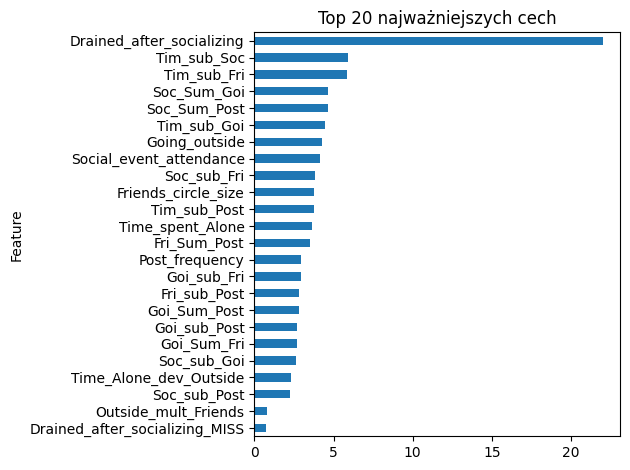

0:	learn: 0.6446157	total: 154ms	remaining: 2m 34s
100:	learn: 0.1256599	total: 7.39s	remaining: 1m 5s
200:	learn: 0.1211237	total: 14.8s	remaining: 58.8s
300:	learn: 0.1182199	total: 22.5s	remaining: 52.3s
400:	learn: 0.1156524	total: 29.2s	remaining: 43.6s
500:	learn: 0.1128532	total: 35.9s	remaining: 35.7s
600:	learn: 0.1094678	total: 43s	remaining: 28.5s
700:	learn: 0.1054609	total: 50.4s	remaining: 21.5s
800:	learn: 0.1024771	total: 58.4s	remaining: 14.5s
900:	learn: 0.0996333	total: 1m 5s	remaining: 7.24s
999:	learn: 0.0969675	total: 1m 13s	remaining: 0us
0:	learn: 0.6452208	total: 65.3ms	remaining: 1m 5s
100:	learn: 0.1268738	total: 1.97s	remaining: 17.5s
200:	learn: 0.1225972	total: 3.3s	remaining: 13.1s
300:	learn: 0.1191802	total: 4.69s	remaining: 10.9s
400:	learn: 0.1156520	total: 6.12s	remaining: 9.14s
500:	learn: 0.1123526	total: 7.57s	remaining: 7.54s
600:	learn: 0.1089421	total: 8.98s	remaining: 5.96s
700:	learn: 0.1058872	total: 10.4s	remaining: 4.43s
800:	learn: 0.1023

In [254]:

# Wyciągnięcie ważności cech
#importances = best_model.get_feature_importance(Pool(train_df.drop(['id','Personality'], axis=1), train_df['Personality']))
feature_names = X.columns

# DataFrame z ważnościami
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Wyświetlenie najważniejszych cech
plt.figure(figsize=(10, 6))
fi_df.head(30).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.gca().invert_yaxis()
plt.title("Top 20 najważniejszych cech")
plt.tight_layout()
plt.show()

## Optuna

In [253]:
import optuna
from catboost import CatBoostClassifier

def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "iterations": 500,
        "verbose": 0,
        "loss_function": "Logloss"
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_valid)[:,1]
    return roc_auc_score(y_valid, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

best_params = study.best_params

[I 2025-07-28 15:36:09,367] A new study created in memory with name: no-name-9dee3e4c-ab37-4513-8437-680b1f625c75
[W 2025-07-28 15:36:09,372] Trial 0 failed with parameters: {'learning_rate': 0.08151966924151845, 'depth': 7, 'l2_leaf_reg': 5.475620467857127} because of the following error: NameError("name 'X_train' is not defined").
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_36/761270409.py", line 15, in objective
    model.fit(X_train, y_train)
              ^^^^^^^
NameError: name 'X_train' is not defined
[W 2025-07-28 15:36:09,372] Trial 0 failed with value None.


NameError: name 'X_train' is not defined